In [1]:
import pandas as pd
import numpy as np
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve, validation_curve
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LassoCV, ElasticNet, RidgeCV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.pipeline import make_pipeline
df = pd.read_csv('ml.csv', sep=';')

# Define columns to be log-transformed
columns_to_log_transform = ['price']

# Apply log transformation to selected columns
df[columns_to_log_transform] = np.log(df[columns_to_log_transform])

y = df['price']
X = df.drop(columns=['price','Unnamed: 0','days_active','grundskyldspromille'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X.columns)

Index(['area', 'land_area', 'rooms', 'ejerudg', 'distance_to_city',
       'residents', 'municipal_tax_rate', 'age', 'type_Villa', 'energy_B',
       'energy_C', 'energy_D', 'energy_E', 'energy_F', 'energy_G',
       'close_Aarhus', 'close_Copenhagen', 'close_Odense'],
      dtype='object')


In [2]:
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import make_pipeline

def generate_poly_features(X, degree):
    poly = PolynomialFeatures(degree=degree, include_bias=False)
    scaler = StandardScaler()
    pipeline = make_pipeline(poly, scaler)
    return pipeline.fit_transform(X)

X_train_poly1 = generate_poly_features(X_train, 1)
X_train_poly2 = generate_poly_features(X_train, 2)
X_train_poly3 = generate_poly_features(X_train, 3)

X_test_poly1 = generate_poly_features(X_test, 1)
X_test_poly2 = generate_poly_features(X_test, 2)
X_test_poly3 = generate_poly_features(X_test, 3)

X_train_poly1.shape, X_train_poly2.shape, X_train_poly3.shape


((20897, 18), (20897, 189), (20897, 1329))

In [3]:
from sklearn.linear_model import Lasso, Ridge, ElasticNet
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Define a function to evaluate regression models
def evaluate_regression(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    # Calculate metrics
    mse_train = mean_squared_error(y_train, y_pred_train)
    mse_test = mean_squared_error(y_test, y_pred_test)
    rmse_train = np.sqrt(mse_train)
    rmse_test = np.sqrt(mse_test)
    mae_train = mean_absolute_error(y_train, y_pred_train)
    mae_test = mean_absolute_error(y_test, y_pred_test)
    r2_train = r2_score(y_train, y_pred_train)
    r2_test = r2_score(y_test, y_pred_test)
    
    results = {
        'MSE_train': mse_train,
        'MSE_test': mse_test,
        'RMSE_train': rmse_train,
        'RMSE_test': rmse_test,
        'MAE_train': mae_train,
        'MAE_test': mae_test,
        'R2_train': r2_train,
        'R2_test': r2_test,
        'y_pred_train': y_pred_train,
        'y_pred_test': y_pred_test
    }
    return results

# # Create regression models
# lasso = Lasso(max_iter=10000)
# ridge = Ridge(max_iter=10000)
# elastic_net = ElasticNet(max_iter=10000)

# # Evaluate models using polynomial degree 1 features
# results_lasso_poly1 = evaluate_regression(lasso, X_train_poly1, y_train, X_test_poly1, y_test)
# results_ridge_poly1 = evaluate_regression(ridge, X_train_poly1, y_train, X_test_poly1, y_test)
# results_en_poly1 = evaluate_regression(elastic_net, X_train_poly1, y_train, X_test_poly1, y_test)

# results_lasso_poly1['MSE_train'], results_ridge_poly1['MSE_train'], results_en_poly1['MSE_train']


In [4]:
from sklearn.model_selection import GridSearchCV

# Define a range of alpha values for the grid search
alpha_values = np.logspace(-6, 6, 10)

# GridSearchCV for Lasso with 1st-degree polynomial features
lasso_grid = GridSearchCV(Lasso(max_iter=10000), param_grid={'alpha': alpha_values}, scoring='neg_mean_squared_error', cv=5, n_jobs=-1)
lasso_grid.fit(X_train_poly1, y_train)

# Extract best hyperparameters and retrain the model
best_alpha_lasso_poly1 = lasso_grid.best_params_['alpha']
lasso_best_poly1 = Lasso(alpha=best_alpha_lasso_poly1, max_iter=10000)
results_lasso_best_poly1 = evaluate_regression(lasso_best_poly1, X_train_poly1, y_train, X_test_poly1, y_test)

best_alpha_lasso_poly1, results_lasso_best_poly1['MSE_train']


(1e-06, 0.1531922353577579)

In [5]:
alpha_values = np.logspace(-6,6, 10)

# GridSearchCV for Ridge with 1st-degree polynomial features
ridge_grid = GridSearchCV(Ridge(max_iter=10000), param_grid={'alpha': alpha_values}, scoring='neg_mean_squared_error', cv=5, n_jobs=-1)
ridge_grid.fit(X_train_poly1, y_train)

# Extract best hyperparameters and retrain the model
best_alpha_ridge_poly1 = ridge_grid.best_params_['alpha']
ridge_best_poly1 = Ridge(alpha=best_alpha_ridge_poly1, max_iter=10000)
results_ridge_best_poly1 = evaluate_regression(ridge_best_poly1, X_train_poly1, y_train, X_test_poly1, y_test)

# GridSearchCV for ElasticNet with 1st-degree polynomial features
elastic_net_grid = GridSearchCV(ElasticNet(max_iter=10000), param_grid={'alpha': alpha_values}, scoring='neg_mean_squared_error', cv=5, n_jobs=-1)
elastic_net_grid.fit(X_train_poly1, y_train)

# Extract best hyperparameters and retrain the model
best_alpha_en_poly1 = elastic_net_grid.best_params_['alpha']
elastic_net_best_poly1 = ElasticNet(alpha=best_alpha_en_poly1, max_iter=10000)
results_en_best_poly1 = evaluate_regression(elastic_net_best_poly1, X_train_poly1, y_train, X_test_poly1, y_test)

best_alpha_ridge_poly1, results_ridge_best_poly1['MSE_train'], best_alpha_en_poly1, results_en_best_poly1['MSE_train']


(4.641588833612772, 0.153192294542226, 1e-06, 0.1531922353002922)

# GridSearchCV and retrain for 2nd-degree polynomial features

In [6]:


# Lasso
lasso_grid.fit(X_train_poly2, y_train)
best_alpha_lasso_poly2 = lasso_grid.best_params_['alpha']
lasso_best_poly2 = Lasso(alpha=best_alpha_lasso_poly2, max_iter=10000)
results_lasso_best_poly2 = evaluate_regression(lasso_best_poly2, X_train_poly2, y_train, X_test_poly2, y_test)




In [ ]:

# Ridge
ridge_grid.fit(X_train_poly2, y_train)
best_alpha_ridge_poly2 = ridge_grid.best_params_['alpha']
ridge_best_poly2 = Ridge(alpha=best_alpha_ridge_poly2, max_iter=10000)
results_ridge_best_poly2 = evaluate_regression(ridge_best_pol

In [ ]:
y2, X_train_poly2, y_train, X_test_poly2, y_test)

# ElasticNet
elastic_net_grid.fit(X_train_poly2, y_train)
best_alpha_en_poly2 = elastic_net_grid.best_params_['alpha']
elastic_net_best_poly2 = ElasticNet(alpha=best_alpha_en_poly2, max_iter=10000)
results_en_best_poly2 = evaluate_regression(elastic_net_best_poly2, X_train_poly2, y_train, X_test_poly2, y_test)


# GridSearchCV and retrain for 3rd-degree polynomial features

In [ ]:
# Lasso
lasso_grid.fit(X_train_poly3, y_train)
best_alpha_lasso_poly3 = lasso_grid.best_params_['alpha']
lasso_best_poly3 = Lasso(alpha=best_alpha_lasso_poly3, max_iter=10000)
results_lasso_best_poly3 = evaluate_regression(lasso_best_poly3, X_train_poly3, y_train, X_test_poly3, y_test)


In [ ]:

# Ridge
ridge_grid.fit(X_train_poly3, y_train)
best_alpha_ridge_poly3 = ridge_grid.best_params_['alpha']
ridge_best_poly3 = Ridge(alpha=best_alpha_ridge_poly3, max_iter=10000)
results_ridge_best_poly3 = evaluate_regression(ridge_best_poly3, X_train_poly3, y_train, X_test_poly3, y_test)



In [ ]:
# ElasticNet
elastic_net_grid.fit(X_train_poly3, y_train)
best_alpha_en_poly3 = elastic_net_grid.best_params_['alpha']
elastic_net_best_poly3 = ElasticNet(alpha=best_alpha_en_poly3, max_iter=10000)
results_en_best_poly3 = evaluate_regression(elastic_net_best_poly3, X_train_poly3, y_train, X_test_poly3, y_test)



In [ ]:
best_alpha_lasso_poly2, results_lasso_best_poly2['MSE_train'], best_alpha_ridge_poly2, results_ridge_best_poly2['MSE_train'], best_alpha_en_poly2, results_en_best_poly2['MSE_train'], best_alpha_lasso_poly3, results_lasso_best_poly3['MSE_train'], best_alpha_ridge_poly3, results_ridge_best_poly3['MSE_train'], best_alpha_en_poly3, results_en_best_poly3['MSE_train']


In [ ]:
# Evaluate models using polynomial degree 2 features
results_lasso_poly2 = evaluate_regression(lasso, X_train_poly2, y_train, X_test_poly2, y_test)
results_ridge_poly2 = evaluate_regression(ridge, X_train_poly2, y_train, X_test_poly2, y_test)
results_en_poly2 = evaluate_regression(elastic_net, X_train_poly2, y_train, X_test_poly2, y_test)

# Evaluate models using polynomial degree 3 features
results_lasso_poly3 = evaluate_regression(lasso, X_train_poly3, y_train, X_test_poly3, y_test)
results_ridge_poly3 = evaluate_regression(ridge, X_train_poly3, y_train, X_test_poly3, y_test)
results_en_poly3 = evaluate_regression(elastic_net, X_train_poly3, y_train, X_test_poly3, y_test)

results_lasso_poly2['MSE_train'], results_ridge_poly2['MSE_train'], results_en_poly2['MSE_train'], results_lasso_poly3['MSE_train'], results_ridge_poly3['MSE_train'], results_en_poly3['MSE_train']


(0.5897931597500282,
 0.1112606656913192,
 0.5108980687012771,
 0.5897931597500282,
 0.09153786072727937,
 0.5078489045760525)

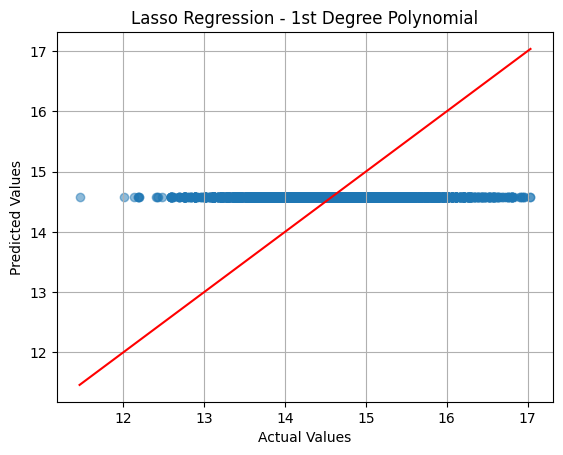

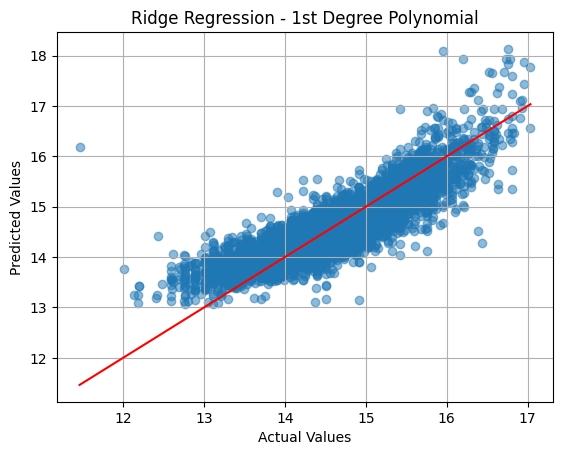

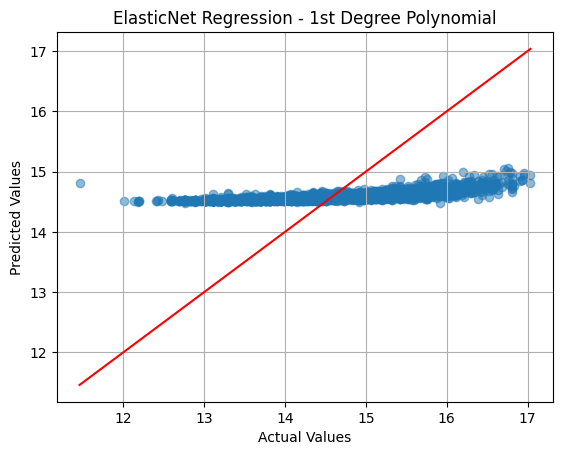

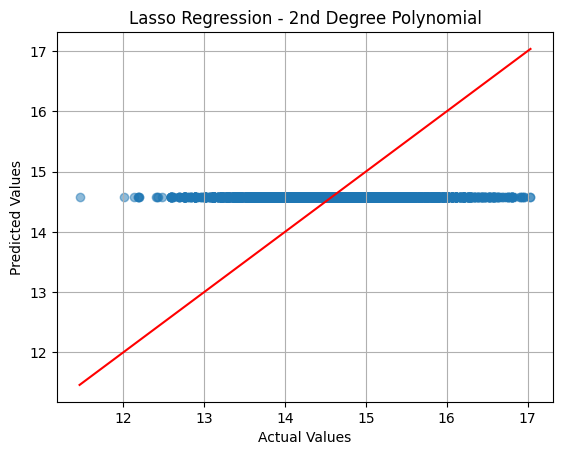

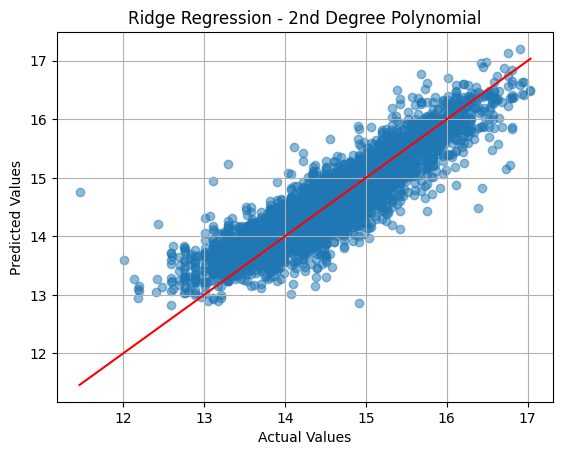

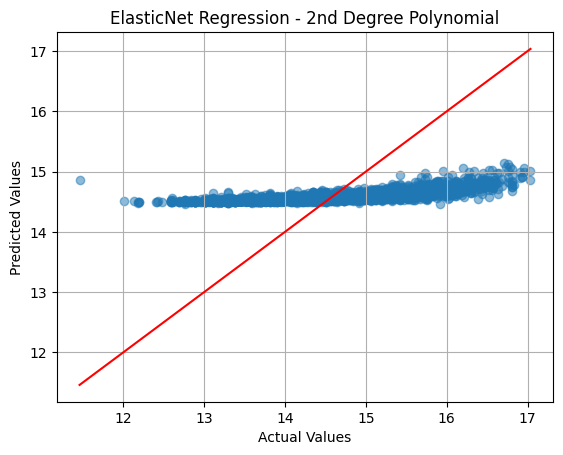

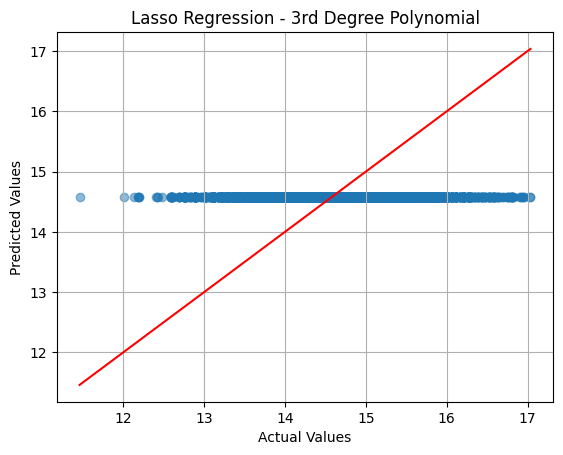

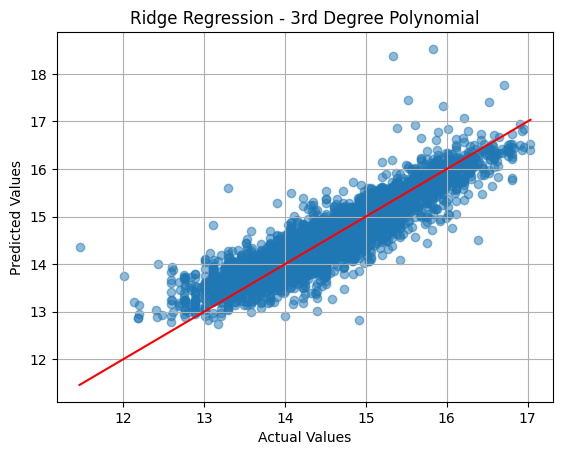

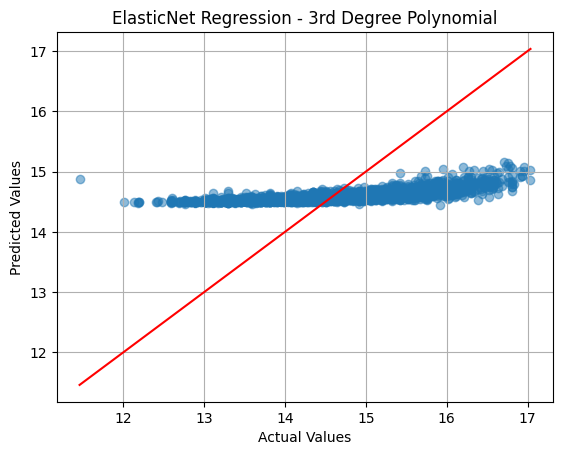

In [ ]:
import matplotlib.pyplot as plt

def plot_actual_vs_predicted(y_actual, y_pred, title):
    plt.scatter(y_actual, y_pred, alpha=0.5)
    plt.plot([min(y_actual), max(y_actual)], [min(y_actual), max(y_actual)], color='red')  # diagonal line
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.title(title)
    plt.grid(True)
    plt.show()

# Plotting for 1st-degree polynomial
plot_actual_vs_predicted(y_test, results_lasso_poly1['y_pred_test'], "Lasso Regression - 1st Degree Polynomial")
plot_actual_vs_predicted(y_test, results_ridge_poly1['y_pred_test'], "Ridge Regression - 1st Degree Polynomial")
plot_actual_vs_predicted(y_test, results_en_poly1['y_pred_test'], "ElasticNet Regression - 1st Degree Polynomial")

# Plotting for 2nd-degree polynomial
plot_actual_vs_predicted(y_test, results_lasso_poly2['y_pred_test'], "Lasso Regression - 2nd Degree Polynomial")
plot_actual_vs_predicted(y_test, results_ridge_poly2['y_pred_test'], "Ridge Regression - 2nd Degree Polynomial")
plot_actual_vs_predicted(y_test, results_en_poly2['y_pred_test'], "ElasticNet Regression - 2nd Degree Polynomial")

# Plotting for 3rd-degree polynomial
plot_actual_vs_predicted(y_test, results_lasso_poly3['y_pred_test'], "Lasso Regression - 3rd Degree Polynomial")
plot_actual_vs_predicted(y_test, results_ridge_poly3['y_pred_test'], "Ridge Regression - 3rd Degree Polynomial")
plot_actual_vs_predicted(y_test, results_en_poly3['y_pred_test'], "ElasticNet Regression - 3rd Degree Polynomial")


In [ ]:
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=None, train_sizes=np.linspace(0.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    plt.legend(loc="best")
    return plt



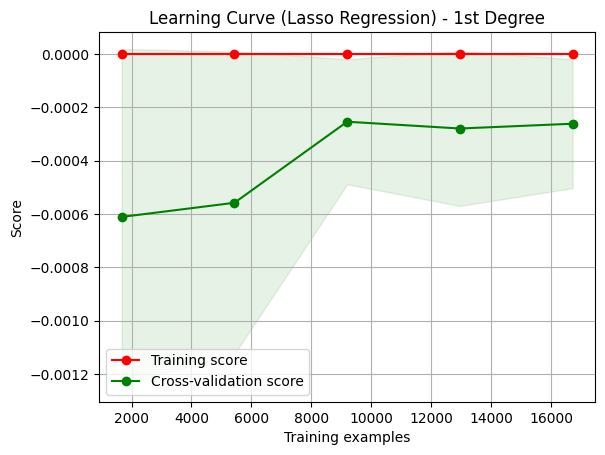

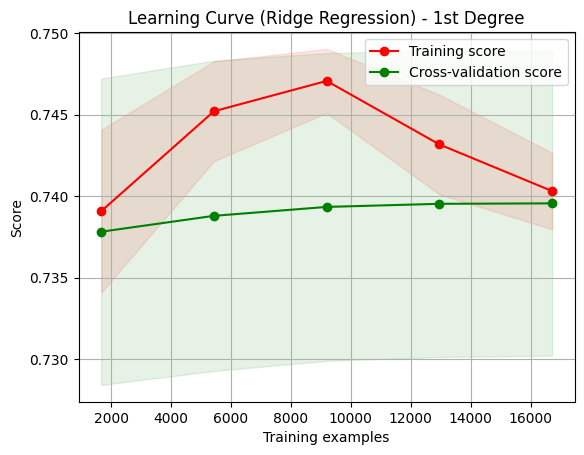

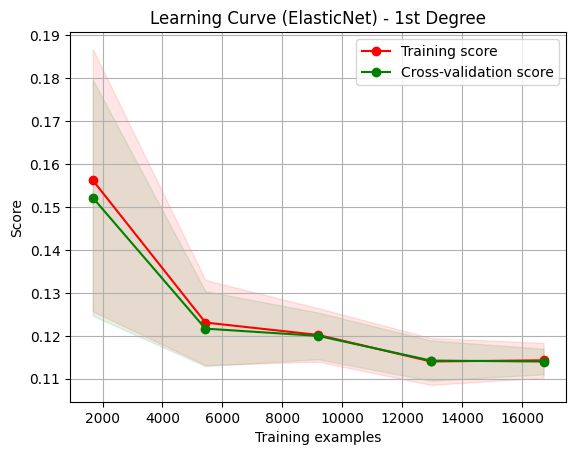

In [ ]:
# Plotting learning curves for 1st-degree polynomial
plot_learning_curve(lasso, "Learning Curve (Lasso Regression) - 1st Degree", X_train_poly1, y_train, n_jobs=-1)
plot_learning_curve(ridge, "Learning Curve (Ridge Regression) - 1st Degree", X_train_poly1, y_train, n_jobs=-1)
plot_learning_curve(elastic_net, "Learning Curve (ElasticNet) - 1st Degree", X_train_poly1, y_train, n_jobs=-1)


plt.show()


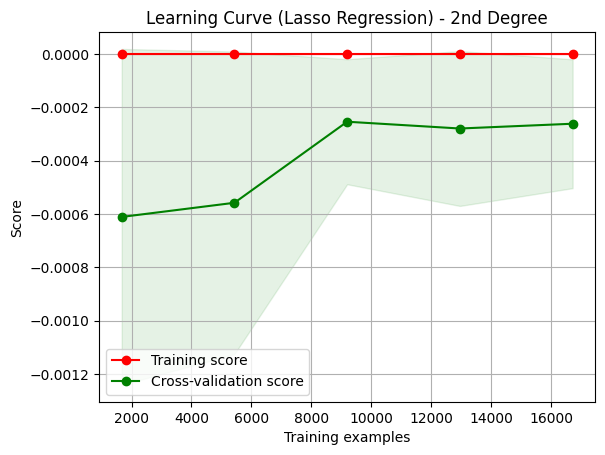

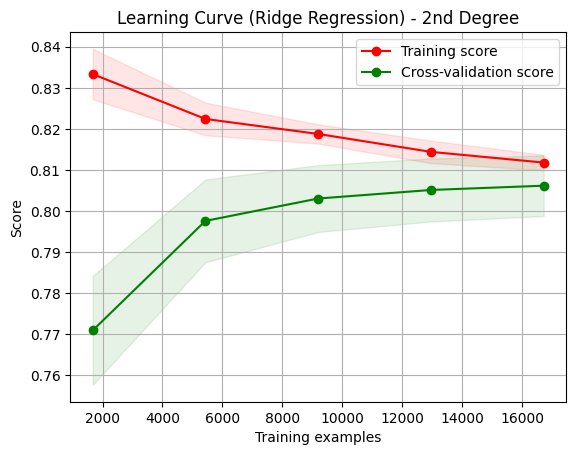

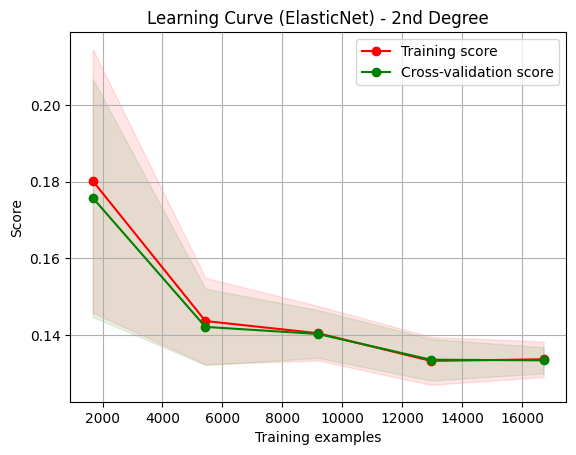

In [ ]:
# Plotting learning curves for 2nd-degree polynomial
plot_learning_curve(lasso, "Learning Curve (Lasso Regression) - 2nd Degree", X_train_poly2, y_train, n_jobs=-1)
plot_learning_curve(ridge, "Learning Curve (Ridge Regression) - 2nd Degree", X_train_poly2, y_train, n_jobs=-1)
plot_learning_curve(elastic_net, "Learning Curve (ElasticNet) - 2nd Degree", X_train_poly2, y_train, n_jobs=-1)

plt.show()


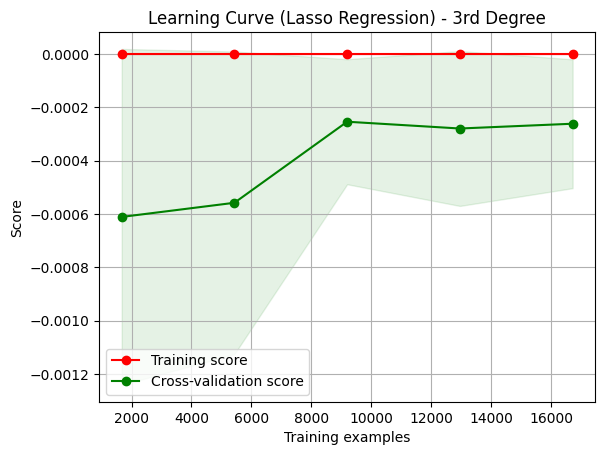

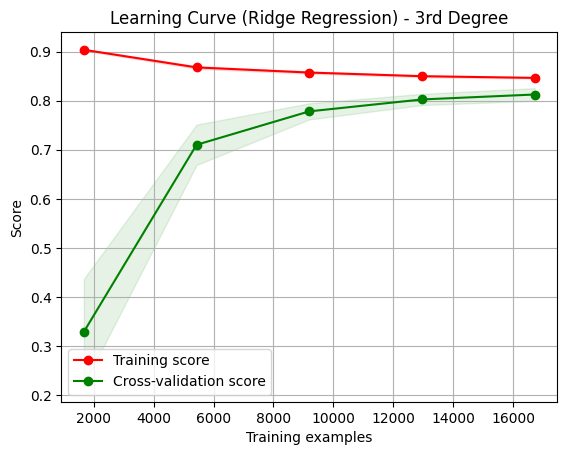

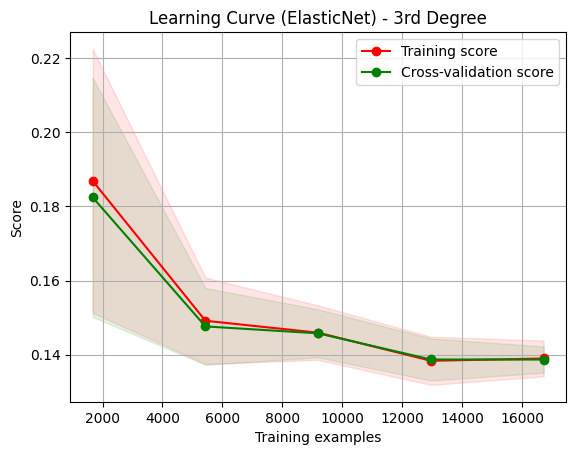

In [ ]:
# Plotting learning curves for 3rd-degree polynomial
plot_learning_curve(lasso, "Learning Curve (Lasso Regression) - 3rd Degree", X_train_poly3, y_train, n_jobs=-1)
plot_learning_curve(ridge, "Learning Curve (Ridge Regression) - 3rd Degree", X_train_poly3, y_train, n_jobs=-1)
plot_learning_curve(elastic_net, "Learning Curve (ElasticNet) - 3rd Degree", X_train_poly3, y_train, n_jobs=-1)

plt.show()


In [ ]:
from sklearn.model_selection import validation_curve

def plot_validation_curve(estimator, title, X, y, param_name, param_range, cv=None, scoring=None, n_jobs=None):
    train_scores, test_scores = validation_curve(estimator, X, y, param_name=param_name, param_range=param_range, cv=cv, scoring=scoring, n_jobs=n_jobs)
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    plt.figure(figsize=(8, 6))
    plt.title(title)
    plt.xlabel(param_name)
    plt.ylabel("Score")
    plt.ylim(0.0, 1.1)
    lw = 2
    plt.semilogx(param_range, train_scores_mean, label="Training score", color="darkorange", lw=lw)
    plt.fill_between(param_range, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.2, color="darkorange", lw=lw)
    plt.semilogx(param_range, test_scores_mean, label="Cross-validation score", color="navy", lw=lw)
    plt.fill_between(param_range, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.2, color="navy", lw=lw)
    plt.legend(loc="best")
    plt.grid(True)
    plt.show()



In [ ]:
# Plotting validation curves for 1st-degree polynomial features
plot_validation_curve(Lasso(max_iter=10000), "Validation Curve (Lasso) - 1st Degree", X_train_poly1, y_train, "alpha", alpha_values, cv=5, scoring="r2", n_jobs=-1)
plot_validation_curve(Ridge(max_iter=10000), "Validation Curve (Ridge) - 1st Degree", X_train_poly1, y_train, "alpha", alpha_values, cv=5, scoring="r2", n_jobs=-1)
plot_validation_curve(ElasticNet(max_iter=10000), "Validation Curve (ElasticNet) - 1st Degree", X_train_poly1, y_train, "alpha", alpha_values, cv=5, scoring="r2", n_jobs=-1)


In [ ]:
# Plotting validation curves for 2nd-degree polynomial features
plot_validation_curve(Lasso(max_iter=10000), "Validation Curve (Lasso) - 2nd Degree", X_train_poly2, y_train, "alpha", alpha_values, cv=5, scoring="r2", n_jobs=-1)
plot_validation_curve(Ridge(max_iter=10000), "Validation Curve (Ridge) - 2nd Degree", X_train_poly2, y_train, "alpha", alpha_values, cv=5, scoring="r2", n_jobs=-1)
plot_validation_curve(ElasticNet(max_iter=10000), "Validation Curve (ElasticNet) - 2nd Degree", X_train_poly2, y_train, "alpha", alpha_values, cv=5, scoring="r2", n_jobs=-1)


In [ ]:
# Plotting validation curves for 3rd-degree polynomial features
plot_validation_curve(Lasso(max_iter=10000), "Validation Curve (Lasso) - 3rd Degree", X_train_poly3, y_train, "alpha", alpha_values, cv=5, scoring="r2", n_jobs=-1)
plot_validation_curve(Ridge(max_iter=10000), "Validation Curve (Ridge) - 3rd Degree", X_train_poly3, y_train, "alpha", alpha_values, cv=5, scoring="r2", n_jobs=-1)
plot_validation_curve(ElasticNet(max_iter=10000), "Validation Curve (ElasticNet) - 3rd Degree", X_train_poly3, y_train, "alpha", alpha_values, cv=5, scoring="r2", n_jobs=-1)
